In [1]:
import numpy as np
from random import randint
import matplotlib.pyplot as plt
import corner
import json

import pytensor
from pytensor import tensor as pt
from pytensor.graph.basic import Apply

from pytensor.graph import Apply, Op
from pytensor.tensor.type import TensorType

import jax
from jax import grad, jit, vmap, value_and_grad, random
import jax.numpy as jnp

import pyhf
pyhf.set_backend('jax')
# pyhf.set_backend('numpy')

import pymc as pm
import arviz as az

from pyhf_pymc import prepare_inference
from pyhf_pymc import context_inference

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### Model

In [2]:
N = 3
nBins = N
obs = jnp.array([70.]*N)
model = pyhf.simplemodels.correlated_background([10]*N,[50]*N,[55]*N,[55]*N)

n_samples = 100_000

unconstr_dict = {
    'mu': {'type': 'unconstrained', 'input': [[5.], [1.]]}
}
prior_dict = prepare_inference.prepare_priors(model, unconstr_dict)
prepared_model = prepare_inference.prepare_model(model=model, observations=obs, priors=prior_dict)

### Testing the context API

In [3]:
with context_inference.pyhf_model(prepared_model):
    post_data = pm.sample(10, chains = 1, init='advi')
    post_pred = pm.sample_posterior_predictive(post_data)
    prior_pred = pm.sample_prior_predictive(10)


Only 10 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using advi...


Convergence achieved at 5100
Interrupted at 5,099 [2%]: Average Loss = 24.248
Interrupted at 5,099 [2%]: Average Loss = 24.248


Sampling 1 chain for 1_000 tune and 10 draw iterations (1_000 + 10 draws total) took 0 seconds.


Sampling: [Expected_Data, Normals, Unconstrained]


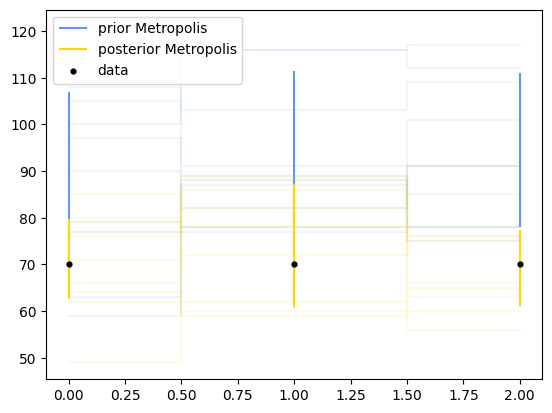

In [12]:
# Prior
plt.step(np.linspace(0,nBins-1,nBins),prior_pred.prior_predictive.Expected_Data[0].T, alpha = 0.1, c = 'cornflowerblue', where = 'mid');
plt.vlines(np.arange(nBins),*np.quantile(prior_pred.prior_predictive.Expected_Data[0],[.15,.85],axis=0), colors = 'cornflowerblue', label='prior Metropolis');

# Posterior
plt.step(np.linspace(0,nBins-1,nBins),post_pred.posterior_predictive.Expected_Data[0].T, alpha = 0.11, c = 'gold', where = 'mid');
plt.vlines(np.arange(nBins),*np.quantile(post_pred.posterior_predictive.Expected_Data[0],[.15,.85],axis=0), colors = 'gold', label='posterior Metropolis')

# Observations
plt.scatter(np.arange(nBins), obs, c = 'k',s=12, zorder = 999, label = "data")
plt.legend(loc='upper left')

plt.title(f'')

plt.show()

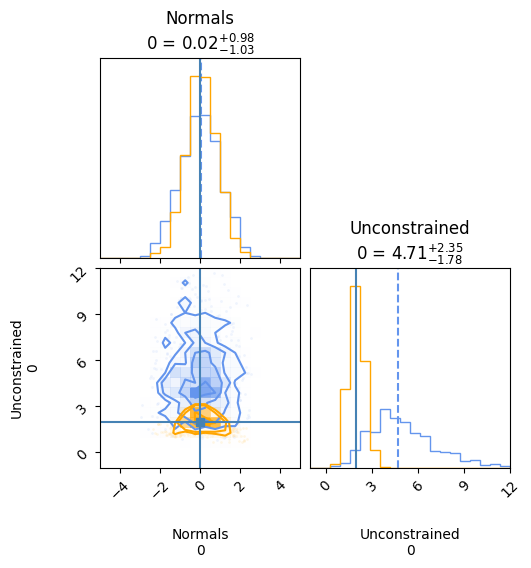

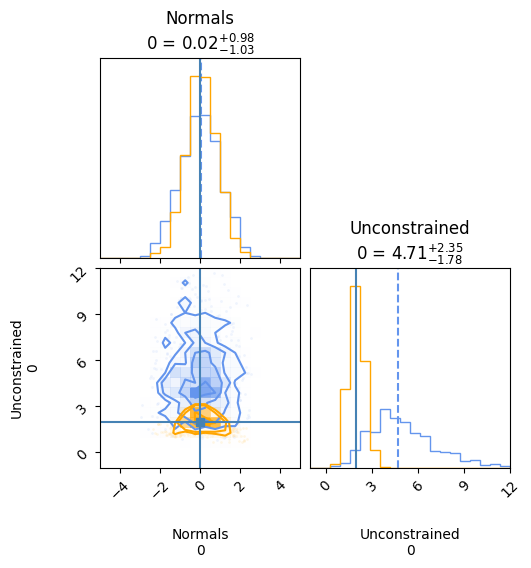

In [23]:
# Parameter Corner Plots
my_range = [(-5, 5), (-1, 12)]
a = corner.corner(prior_pred.prior, quantiles=[0.5], show_titles=True, color='cornflowerblue', range=my_range)
corner.corner(post_data.posterior, color = 'orange', truths=[0., 2.], fig=a, range=my_range)

array([<AxesSubplot: title={'center': 'Normals\n0, 0'}>,
       <AxesSubplot: title={'center': 'Unconstrained\n0, 0'}>],
      dtype=object)

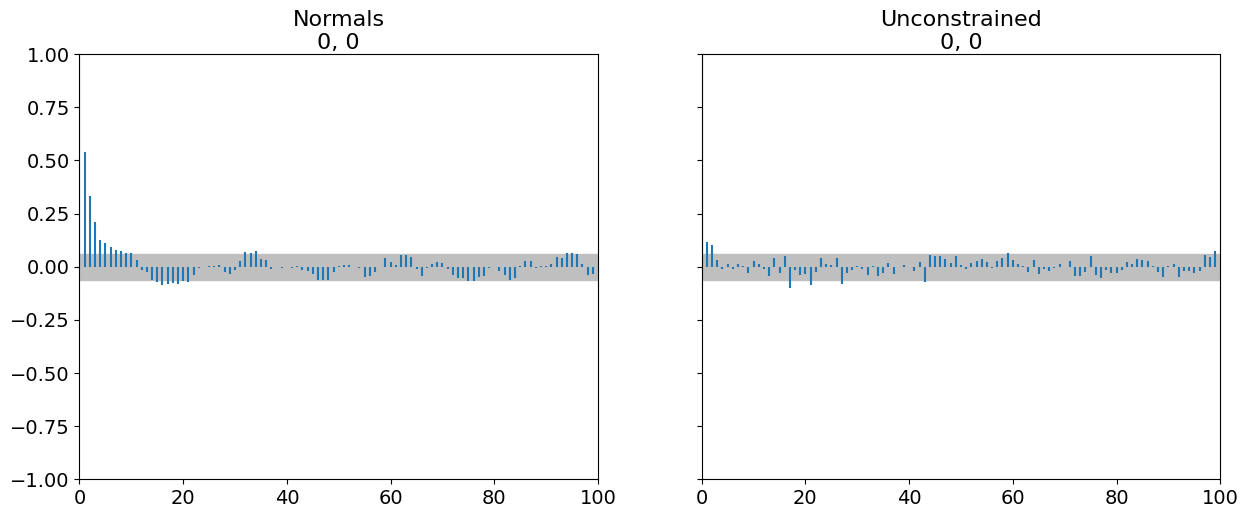

In [28]:
az.plot_autocorr(post_data.posterior)

### Push Forward

In [24]:
from pyhf_pymc import make_op
expData_op = make_op.make_op(model)

In [35]:
with pm.Model() as m:
    pars = prepare_inference.priors2pymc(prepared_model)

    Expected_Data = pm.Deterministic("Expected_Data", expData_op(pars))
    test = pm.sample(10)

Only 10 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Unconstrained, Normals]


Sampling 4 chains for 1_000 tune and 10 draw iterations (4_000 + 40 draws total) took 0 seconds.
/var/folders/p9/sw_pjm3j027cxfs57s_91bfw0000gn/T/ipykernel_7107/1320305191.py:5: UserWarning: The number of samples is too small to check convergence reliably.
  test = pm.sample(10)


In [36]:
test.posterior.Expected_Data[0]

<xarray.DataArray 'Expected_Data' (draw: 10, Expected_Data_dim_0: 3)>
array([[ 85.0536479 ,  85.0536479 ,  85.0536479 ],
       [ 81.23196662,  81.23196662,  81.23196662],
       [142.72370554, 142.72370554, 142.72370554],
       [ 88.9754513 ,  88.9754513 ,  88.9754513 ],
       [ 88.02804248,  88.02804248,  88.02804248],
       [ 99.07880719,  99.07880719,  99.07880719],
       [113.63689637, 113.63689637, 113.63689637],
       [ 82.73919357,  82.73919357,  82.73919357],
       [120.57072311, 120.57072311, 120.57072311],
       [ 98.66197894,  98.66197894,  98.66197894]])
Coordinates:
    chain                int64 0
  * draw                 (draw) int64 0 1 2 3 4 5 6 7 8 9
  * Expected_Data_dim_0  (Expected_Data_dim_0) int64 0 1 2